In [9]:
import os
import sys
import warnings
cur_dir = os.getcwd()
pkg_rootdir = os.path.dirname(cur_dir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
 
from utils import *

import torch
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# 为了进行可视化，当前部分的CIFAR_100_Dataset与实验中使用的版本存在一定程度的不同
class CIFAR_100_Dataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data)
        self.label = torch.tensor(label)
        self._label_num = max(label) + 1
        self._check_param()
    
    def _check_param(self):
        assert len(self.data) == len(self.label)

    def __getitem__(self, idx):
        if isinstance(idx, int) or isinstance(idx, slice) or isinstance(idx, list):
            img = self.data[idx]
            label = F.one_hot(self.label[idx], self._label_num)
            return img, label
        else:
            raise ValueError()
    
    def __len__(self):
        return len(self.data)
    
    def mixup_aug(self, origin_idx, aug_idx, beta):
        lambda_val = np.random.beta(beta, beta)
        img = self.data[origin_idx]
        label = self.label[origin_idx]
        label = F.one_hot(label, self._label_num)

        aug_img = self.data[aug_idx]
        aug_label = self.label[aug_idx]

        aug_label = F.one_hot(aug_label, self._label_num)

        return_img = img.clone()
        return_label = label.clone()
        return_img = lambda_val * img + (1 - lambda_val) * aug_img
        return_label = lambda_val * label + (1 - lambda_val) * aug_label
        return return_img, return_label, lambda_val

    def cutmix_aug(self, origin_idx, aug_idx, beta):
        lambda_val = np.random.beta(beta, beta)

        img = self.data[origin_idx]
        label = self.label[origin_idx]
        label = F.one_hot(label, self._label_num)
        aug_img = self.data[aug_idx]
        aug_label = self.label[aug_idx]
        aug_label = F.one_hot(aug_label, self._label_num)

        img_height = img.shape[0]
        img_width = img.shape[1]
        
        cut_rate = np.sqrt(1 - lambda_val)
        cut_height = int(img_height * cut_rate)
        cut_width = int(img_width * cut_rate)
        height_idx = np.random.randint(img_height)
        width_idx = np.random.randint(img_width)
        reindex_cut_height_lower = np.clip(height_idx - cut_height // 2, 0, img_height)
        reindex_cut_height_upper = np.clip(height_idx + cut_height // 2, 0, img_height)
        reindex_cut_width_lower = np.clip(width_idx - cut_width // 2, 0, img_width)
        reindex_cut_width_upper = np.clip(width_idx + cut_width // 2, 0, img_width)
        
        cut_percent = ((reindex_cut_height_upper - reindex_cut_height_lower) * (reindex_cut_width_upper - reindex_cut_width_lower)) / (img_height * img_width)

        return_img = img.clone()
        return_label = label.clone()
        return_img[reindex_cut_height_lower: reindex_cut_height_upper, reindex_cut_width_lower: reindex_cut_width_upper, :] = aug_img[reindex_cut_height_lower: reindex_cut_height_upper, reindex_cut_width_lower: reindex_cut_width_upper, :]
        return_label = (1 - cut_percent) * label + cut_percent * aug_label
        return return_img, return_label

    def cutout_aug(self, origin_idx, beta):
        lambda_val = np.random.beta(beta, beta)
        img = self.data[origin_idx]
        label = self.label[origin_idx]
        label = F.one_hot(label, self._label_num)

        img_height = img.shape[0]
        img_width = img.shape[1]
        cut_rate = np.sqrt(1 - lambda_val)
        cut_height = int(img_height * cut_rate)
        cut_width = int(img_width * cut_rate)
        height_idx = np.random.randint(img_height)
        width_idx = np.random.randint(img_width)
        reindex_cut_height_lower = np.clip(height_idx - cut_height // 2, 0, img_height)
        reindex_cut_height_upper = np.clip(height_idx + cut_height // 2, 0, img_height)
        reindex_cut_width_lower = np.clip(width_idx - cut_width // 2, 0, img_width)
        reindex_cut_width_upper = np.clip(width_idx + cut_width // 2, 0, img_width)

        return_img = img.clone()
        return_img[reindex_cut_height_lower: reindex_cut_height_upper, reindex_cut_width_lower: reindex_cut_width_upper, :] = 0
        return return_img, label

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.0203, 0.1994, 0.2010])])
cifar_dataset = datasets.cifar.CIFAR100('./dataset/cifar100', train=True, transform=transform)
origin_dataset = CIFAR_100_Dataset(cifar_dataset.data / 255, cifar_dataset.targets)

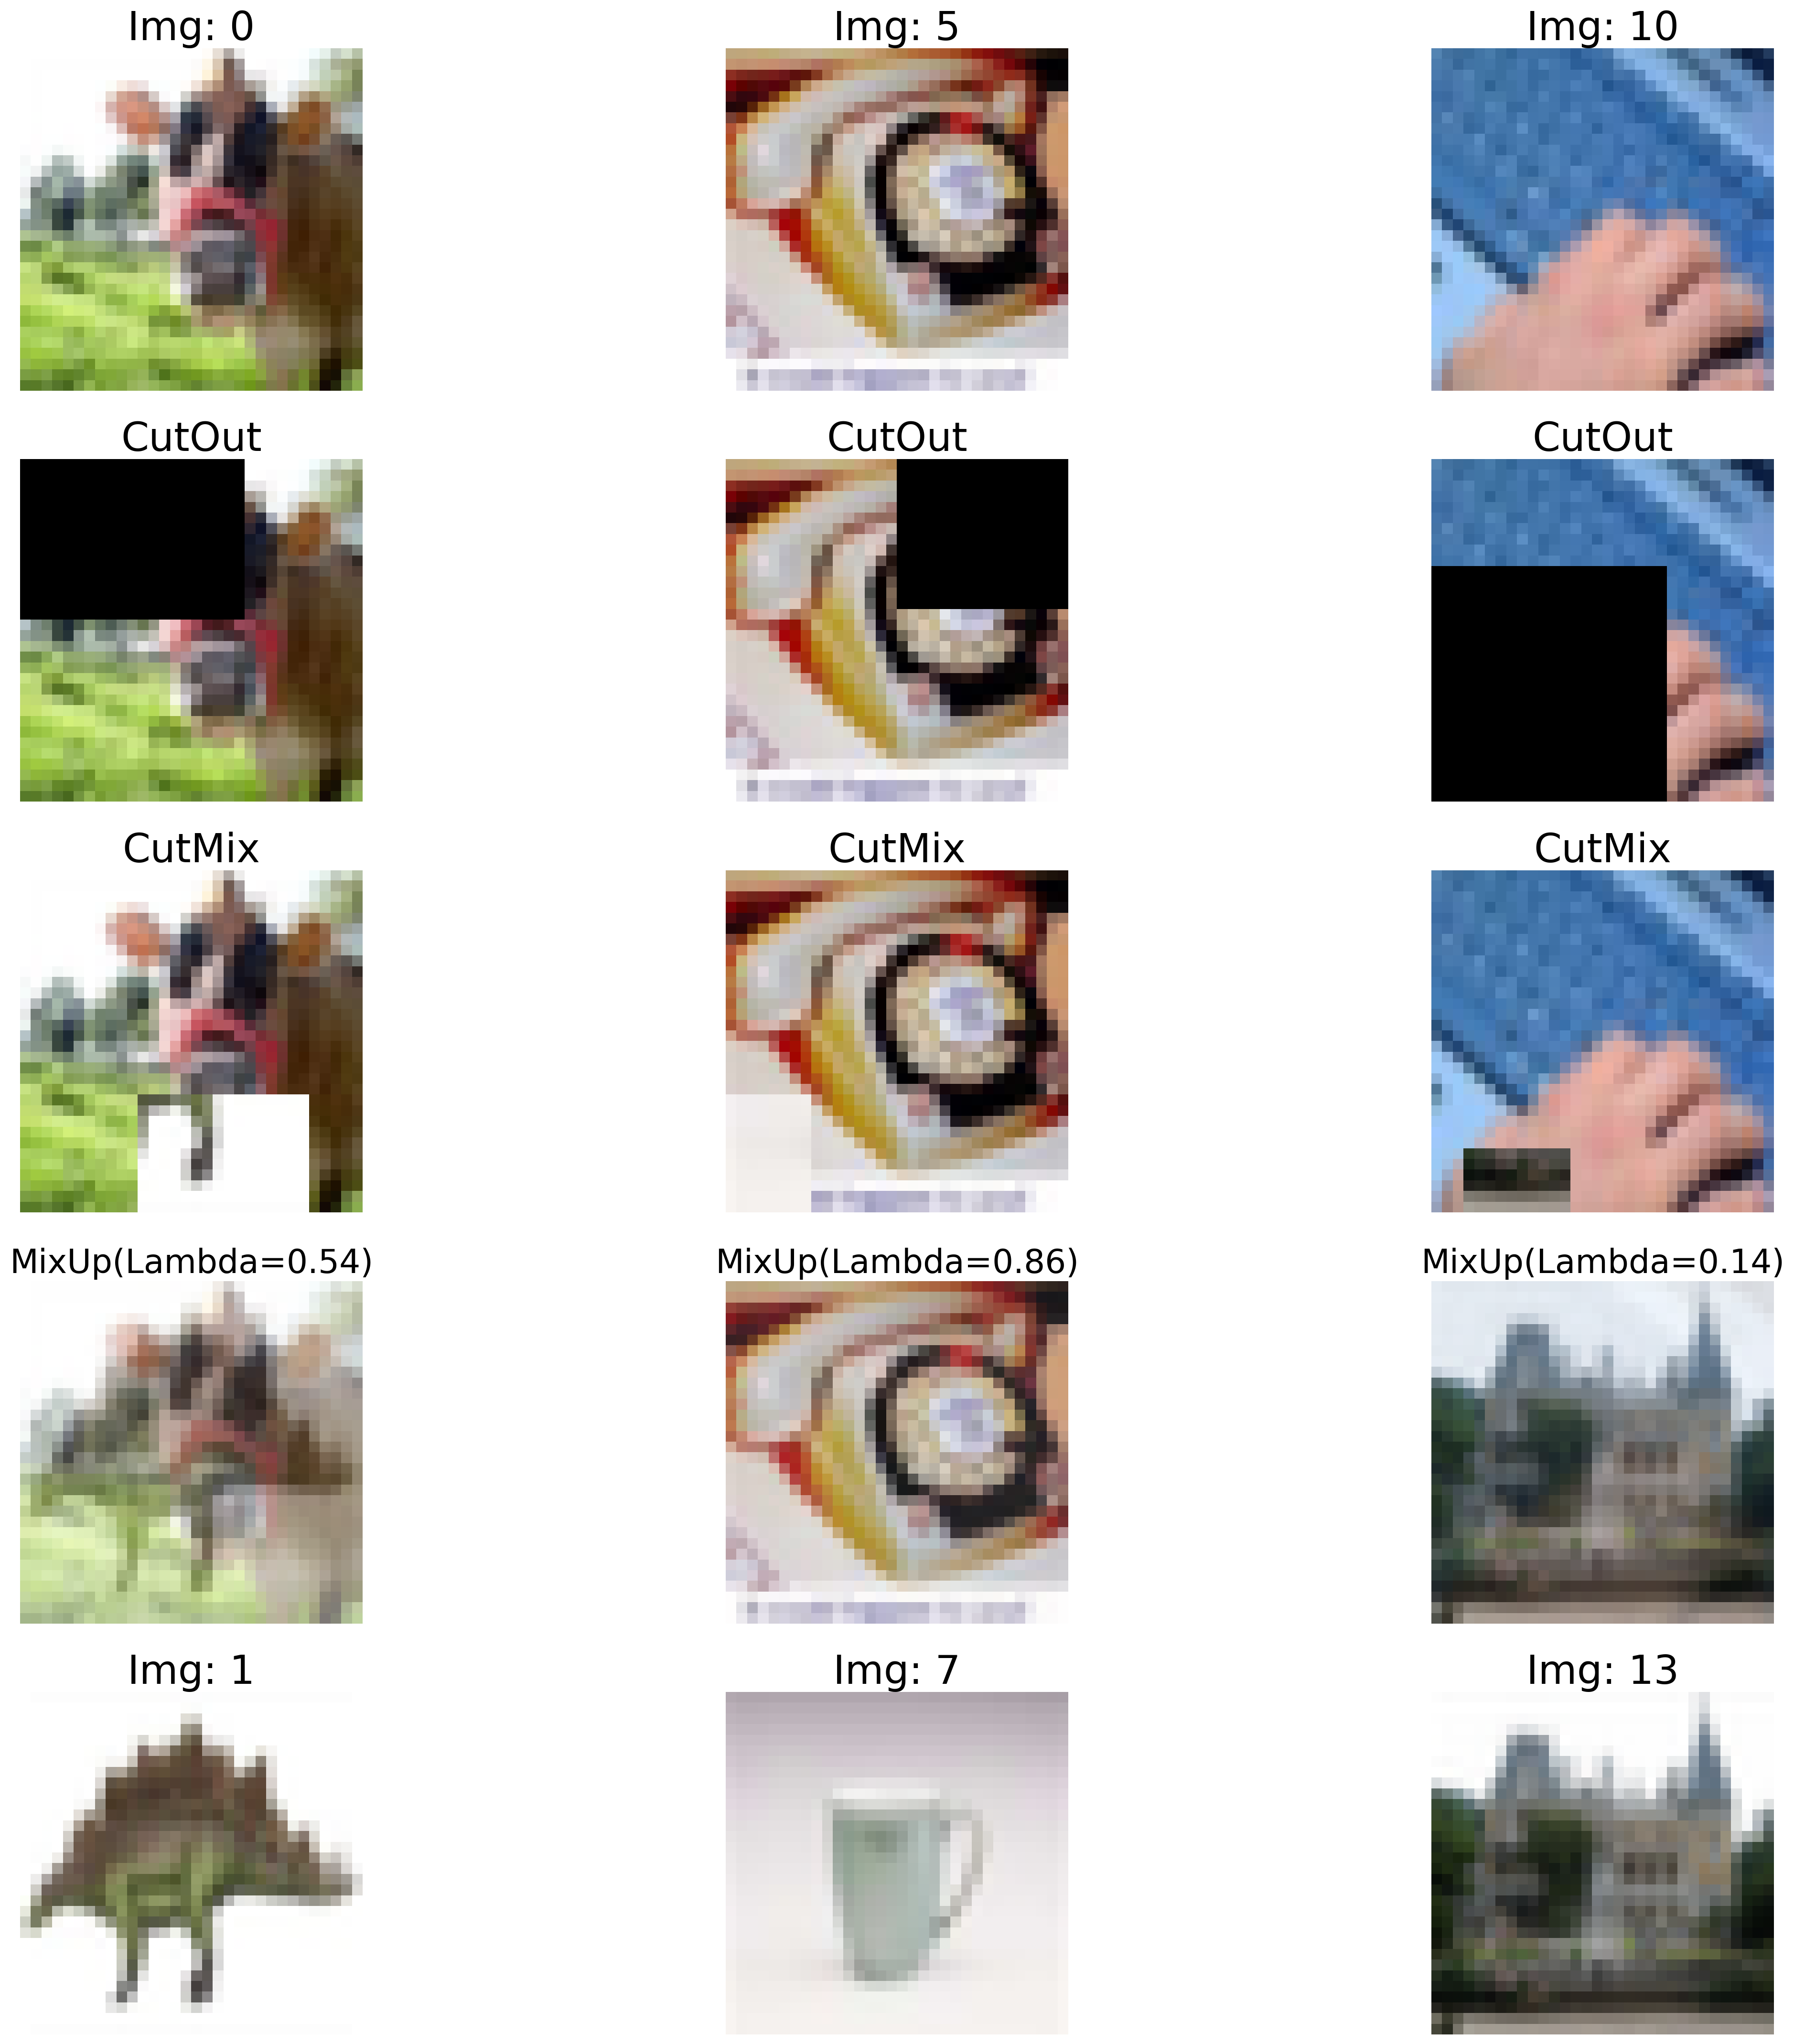

In [12]:
plt.figure(dpi=200, figsize=(27, 27))
org1 = origin_dataset[0][0]
org2 = origin_dataset[5][0]
org3 = origin_dataset[10][0]

aug1 = origin_dataset[1][0]
aug2 = origin_dataset[7][0]
aug3 = origin_dataset[13][0]

org_list = [org1, org2, org3]
aug_list = [aug1, aug2, aug3]
org_idx_list = [0, 5, 10]
aug_idx_list = [1, 7, 13]

for idx in range(3):
    plt.subplot(5, 3, idx + 1)
    plt.imshow(org_list[idx])
    plt.title(f"Img: {org_idx_list[idx]}", fontsize=30)
    plt.axis('off')

for idx in range(3):
    plt.subplot(5, 3, idx + 4)
    cutout_org = origin_dataset.cutout_aug(origin_idx=org_idx_list[idx], beta=1)[0]
    plt.imshow(cutout_org)
    plt.title(f"CutOut", fontsize=30)
    plt.axis('off')

for idx in range(3):
    plt.subplot(5, 3, idx + 7)
    cutmix_org = origin_dataset.cutmix_aug(origin_idx=org_idx_list[idx], aug_idx=aug_idx_list[idx] ,beta=1)[0]
    plt.imshow(cutmix_org)
    plt.title(f"CutMix", fontsize=30)
    plt.axis('off')

for idx in range(3):
    plt.subplot(5, 3, idx + 10)
    mixup_org, _, lambda_val = origin_dataset.mixup_aug(origin_idx=org_idx_list[idx], aug_idx=aug_idx_list[idx], beta=1)
    plt.imshow(mixup_org)
    plt.title(f"MixUp(Lambda={round(lambda_val, 2)})", fontsize=25)
    plt.axis('off')

for idx in range(3):
    plt.subplot(5, 3, idx + 13)
    plt.imshow(aug_list[idx])
    plt.title(f"Img: {aug_idx_list[idx]}", fontsize=30)
    plt.axis('off')